In [125]:
library(tidyverse)
library(faraway)
library(leaps)

In [126]:
industry_returns=read_csv("Industry_Returns.csv")
factor_returns=read_csv("5_Factor_Returns.csv")

Parsed with column specification:
cols(
  Year = col_double(),
  Manuf = col_double(),
  HiTec = col_double(),
  Utils = col_double(),
  RF = col_double()
)
Parsed with column specification:
cols(
  Year = col_double(),
  `Mkt-RF` = col_double(),
  SMB = col_double(),
  HML = col_double(),
  RMW = col_double(),
  CMA = col_double()
)


In [127]:
head(industry_returns)
head(factor_returns)

Year,Manuf,HiTec,Utils,RF
198001,7.02,7.37,1.60,0.80
198002,-2.65,-3.56,-3.36,0.89
198003,-11.68,-12.67,-6.67,1.21
198004,3.25,0.72,11.96,1.26
198005,6.18,4.82,4.61,0.81
198006,2.41,3.03,4.54,0.61


Year,Mkt-RF,SMB,HML,RMW,CMA
196307,-0.39,-0.47,-0.83,0.66,-1.15
196308,5.07,-0.79,1.67,0.39,-0.40
196309,-1.57,-0.48,0.18,-0.76,0.24
196310,2.53,-1.29,-0.10,2.75,-2.24
196311,-0.85,-0.84,1.71,-0.45,2.22
196312,1.83,-1.89,-0.12,0.08,-0.30


In [128]:
industry_returns = industry_returns %>% mutate(`Manuf-RF` = 
    Manuf-RF, `HiTec-RF` = HiTec-RF, `Utils-RF` = Utils-RF)
                                                          

In [129]:
aggregate = inner_join(factor_returns, industry_returns, by="Year")
aggregate = aggregate %>% na.omit()

In [130]:
#Manufacturing Industry Analysis

lmod_Manuf=lm(`Manuf-RF` ~ `Mkt-RF`+`SMB`+`HML`, data = aggregate)
#summary(lmod_Manuf)
#par(mfrow = c(2,2)); plot(lmod_Manuf)

In [131]:
#Model Selection through Backwards Elimination (15% level)

lmod_Manuf = update(lmod_Manuf, .~.-SMB)
summary(lmod_Manuf)


Call:
lm(formula = `Manuf-RF` ~ `Mkt-RF` + HML, data = aggregate)

Residuals:
    Min      1Q  Median      3Q     Max 
-5.7831 -1.0759  0.0351  1.0298  6.1166 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.003191   0.085478  -0.037     0.97    
`Mkt-RF`     1.065819   0.019797  53.837  < 2e-16 ***
HML          0.198946   0.029616   6.718 5.56e-11 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.786 on 453 degrees of freedom
Multiple R-squared:  0.8677,	Adjusted R-squared:  0.8672 
F-statistic:  1486 on 2 and 453 DF,  p-value: < 2.2e-16


The preffered model by Backwards Elimination is:

l2_Manuf = lm(`Manuf-RF` ~ `Mkt-RF`+`HML`, data = aggregate)

In [132]:
#Model Selection through Minimized AIC

b_Manuf = regsubsets(`Manuf-RF` ~ `Mkt-RF`+`SMB`+`HML`, data = aggregate)
rs_Manuf = summary(b_Manuf)
rs_Manuf$which 


(Intercept),`Mkt-RF`,SMB,HML
TRUE,TRUE,FALSE,FALSE
TRUE,TRUE,FALSE,TRUE
TRUE,TRUE,TRUE,TRUE


In [133]:
l1_Manuf = lm(`Manuf-RF` ~ `Mkt-RF`, data = aggregate)
l2_Manuf = lm(`Manuf-RF` ~ `Mkt-RF`+`HML`, data = aggregate)
l3_Manuf = lm(`Manuf-RF` ~ `Mkt-RF`+`SMB`+`HML`, data = aggregate)

AIC(l1_Manuf)
AIC(l2_Manuf)
AIC(l3_Manuf)

[1] 1869.331

[1] 1828.029

[1] 1828.422

The model that minimizes AIC is:

l2_Manuf = lm(`Manuf-RF` ~ `Mkt-RF`+`HML`, data = aggregate)

In [134]:
#Model Selection through Maximization of Adjusted R-Squared

rs_Manuf$adjr2

[1] 0.8542408 0.8671527 0.8673272

The model that maximizes Adjusted R-Squared is: 

l3_Manuf = lm(`Manuf-RF` ~ `Mkt-RF`+`SMB`+`HML`, data = aggregate)

In [135]:
#LOOCV MANUF

LOOCV_MANUF_3 = function(df){
    sum_square_dev = 0
    for (i in 1:dim(df)[1]){
        test = df[i,]
        train = df[-i,]
        lmod = lm(`Manuf-RF` ~ `Mkt-RF`+`SMB`+`HML`, data = train)
        modelMatrix = model.matrix(lmod)
        newData = data.frame(aggregate[i,])%>% select(2:4)
        newData = newData %>% rename(`Mkt-RF` = `Mkt.RF`)
        predict = predict(lmod, newdata = newData)[[1]]
        ManufActual = aggregate[i,] %>% select(11:11)
        true = ManufActual[[1]]
        
        square_dev = (true - predict)^2
        sum_square_dev = sum_square_dev + square_dev
    }
    mean_sum_square_dev = mean(sum_square_dev)
    return(mean_sum_square_dev)
}

LOOCV_MANUF_2 = function(df){
    sum_square_dev = 0
    for (i in 1:dim(df)[1]){
        test = df[i,]
        train = df[-i,]
        lmod = lm(`Manuf-RF` ~ `Mkt-RF`+`HML`, data = train)
        modelMatrix = model.matrix(lmod)
        newData = data.frame(aggregate[1,])%>% select(2:2,4:4)
        newData = newData %>% rename(`Mkt-RF` = `Mkt.RF`)
        predict = predict(lmod, newdata = newData)[[1]]
        ManufActual = aggregate[i,] %>% select(11:11)
        true = ManufActual[[1]]
        
        square_dev = (true - predict)^2
        sum_square_dev = sum_square_dev + square_dev
    }
    mean_sum_square_dev = mean(sum_square_dev)
    return(mean_sum_square_dev)
}

LOOCV_MANUF_1 = function(df){
    sum_square_dev = 0
    for (i in 1:dim(df)[1]){
        test = df[i,]
        train = df[-i,]
        lmod = lm(`Manuf-RF` ~ `Mkt-RF`, data = train)
        modelMatrix = model.matrix(lmod)
        newData = data.frame(aggregate[i,])%>% select(2:2)
        newData = newData %>% rename(`Mkt-RF` = `Mkt.RF`)
        predict = predict(lmod, newdata = newData)[[1]]
        ManufActual = aggregate[i,] %>% select(11:11)
        true = ManufActual[[1]]
        
        square_dev = (true - predict)^2
        sum_square_dev = sum_square_dev + square_dev
    }
    mean_sum_square_dev = mean(sum_square_dev)
    return(mean_sum_square_dev)
}

In [136]:
# Model selection based on minimized Leave-One-Out Cross Validation score:

cat('The manufacturing industry model with all 3 factors has a Leave-One-Out Cross Validation score of: ',LOOCV_MANUF_3(aggregate),"\n")

cat('The manufacturing industry model with Mkt-Rf and HML factors has a Leave-One-Out Cross Validation score of: ',LOOCV_MANUF_2(aggregate),"\n")


The manufacturing industry model with all 3 factors has a Leave-One-Out Cross Validation score of:  1486.684 
The manufacturing industry model with Mkt-Rf and HML factors has a Leave-One-Out Cross Validation score of:  24515.06 


The model which minimizes the Leave-One-Out Cross Validation score:

l3_Manuf = lm(`Manuf-RF` ~ `Mkt-RF`+`SMB`+`HML`, data = aggregate)

In [137]:
# Displaying Summary of Preffered Model

summary(l3_Manuf)


Call:
lm(formula = `Manuf-RF` ~ `Mkt-RF` + SMB + HML, data = aggregate)

Residuals:
    Min      1Q  Median      3Q     Max 
-5.9443 -1.0581  0.0334  1.0592  6.1181 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.005458   0.085441  -0.064    0.949    
`Mkt-RF`     1.061274   0.020109  52.777  < 2e-16 ***
SMB          0.037495   0.029682   1.263    0.207    
HML          0.202102   0.029701   6.804 3.23e-11 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.785 on 452 degrees of freedom
Multiple R-squared:  0.8682,	Adjusted R-squared:  0.8673 
F-statistic: 992.5 on 3 and 452 DF,  p-value: < 2.2e-16


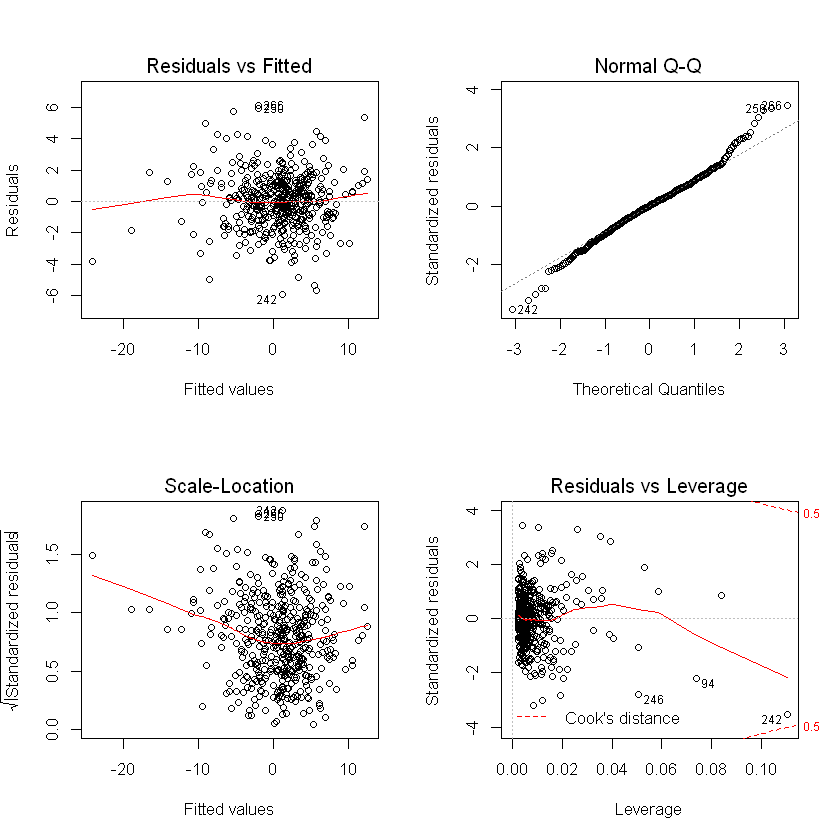

In [138]:
#Check for Violation of Assumptions of Preffered Model

par(mfrow = c(2,2)); plot(l3_Manuf)

There does not appear to be any significant violations in the assumption of regression. There is no linear relationship or curvature in the residual vs fitted plot, hence the linearity assumption is not violated. There is also no trumpeting pattern in the residual vs fitted plot so the constant variance assumption is not violated. While there is some deviation in normality in the tails of the normal q-q plot, this is the least important of the other assumptions. All else equal, unless the sample size is small, results are reasonably robust to deviations in normality.

In [139]:
# Checking for collinearity among predictors 

X_Manuf=model.matrix(l3_Manuf)
ev_Manuf = eigen(t(X_Manuf)%*%X_Manuf)
Condition_Number_Manuf = sqrt(ev_Manuf$values[1]/ev_Manuf$values[length(ev_Manuf$values)])
cat('The condition number for the regression run on the manufacturing industry is :',Condition_Number_Manuf)

The condition number for the regression run on the manufacturing industry is : 4.743328

Because the condition number is less than 30, there is no evidence of collinearity between predictors.

In [140]:
# Further investigation into collinearity among predictors

vif(l3_Manuf)

`Mkt-RF`      SMB      HML 
1.119495 1.052817 1.091377

Furthermore, VIFs of greater than 10 are evidence of collinearity since none of them are greater than 10 then there is no evidence of collinearty.

In [141]:
# Comparing the selected model to single predictor Leave-One-Out Cross Validation score:

cat('The manufacturing industry model with the Mkt-Rf factor only has a Leave-One-Out Cross Validation score of: ',LOOCV_MANUF_1(aggregate))

The manufacturing industry model with the Mkt-Rf factor only has a Leave-One-Out Cross Validation score of:  1609.472

In [142]:
#HiTech Industry Analysis

lmod_HiTec=lm(`HiTec-RF` ~ `Mkt-RF`+`SMB`+`HML`, data = aggregate)
#summary(lmod_HiTec)
#par(mfrow = c(2,2)); plot(lmod_HiTec)

In [143]:
#Model Selection through Backwards Elimination (15% level)
summary(lmod_HiTec)


Call:
lm(formula = `HiTec-RF` ~ `Mkt-RF` + SMB + HML, data = aggregate)

Residuals:
    Min      1Q  Median      3Q     Max 
-9.0704 -1.6237 -0.0907  1.7709  8.1945 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.12095    0.13787   0.877    0.381    
`Mkt-RF`     1.16579    0.03245  35.927  < 2e-16 ***
SMB          0.20117    0.04790   4.200 3.22e-05 ***
HML         -0.64656    0.04793 -13.490  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 2.88 on 452 degrees of freedom
Multiple R-squared:  0.819,	Adjusted R-squared:  0.8178 
F-statistic: 681.6 on 3 and 452 DF,  p-value: < 2.2e-16


The preffered model by Backwards Elimination is:

l3_HiTec = lm(`HiTec-RF` ~ `Mkt-RF`+`SMB`+`HML`, data = aggregate)

In [144]:
#Model Selection through Minimized AIC

b_HiTec = regsubsets(`HiTec-RF` ~ `Mkt-RF`+`SMB`+`HML`, data = aggregate)
rs_HiTec = summary(b_HiTec)
rs_HiTec$which 

(Intercept),`Mkt-RF`,SMB,HML
TRUE,TRUE,FALSE,FALSE
TRUE,TRUE,FALSE,TRUE
TRUE,TRUE,TRUE,TRUE


In [145]:
l1_HiTec = lm(`HiTec-RF` ~ `Mkt-RF`, data = aggregate)
l2_HiTec = lm(`HiTec-RF` ~ `Mkt-RF`+`HML`, data = aggregate)
l3_HiTec = lm(`HiTec-RF` ~ `Mkt-RF`+`SMB`+`HML`, data = aggregate)

AIC(l1_HiTec)
AIC(l2_HiTec)
AIC(l3_HiTec)

[1] 2435.274

[1] 2280.285

[1] 2264.829

The model that minimizes AIC is:

l3_HiTec = lm(`HiTec-RF` ~ `Mkt-RF`+`SMB`+`HML`, data = aggregate)


In [146]:
#Model selection through Maximization of Adjusted R-Squared
rs_HiTec$adjr2

[1] 0.7340087 0.8110664 0.8177602

The model that maximizes Adjusted R-Squared is:

l3_HiTec = lm(`HiTec-RF` ~ `Mkt-RF`+`SMB`+`HML`, data = aggregate)

Because all the methods of selection agree, Leave-One-Out Cross Validation is now necessary to determine the best model. The preffered model is:

l3_HiTec = lm(`HiTec-RF` ~ `Mkt-RF`+`SMB`+`HML`, data = aggregate)

In [147]:
# Display Summary of Preffered Model

summary(l3_HiTec)


Call:
lm(formula = `HiTec-RF` ~ `Mkt-RF` + SMB + HML, data = aggregate)

Residuals:
    Min      1Q  Median      3Q     Max 
-9.0704 -1.6237 -0.0907  1.7709  8.1945 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.12095    0.13787   0.877    0.381    
`Mkt-RF`     1.16579    0.03245  35.927  < 2e-16 ***
SMB          0.20117    0.04790   4.200 3.22e-05 ***
HML         -0.64656    0.04793 -13.490  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 2.88 on 452 degrees of freedom
Multiple R-squared:  0.819,	Adjusted R-squared:  0.8178 
F-statistic: 681.6 on 3 and 452 DF,  p-value: < 2.2e-16


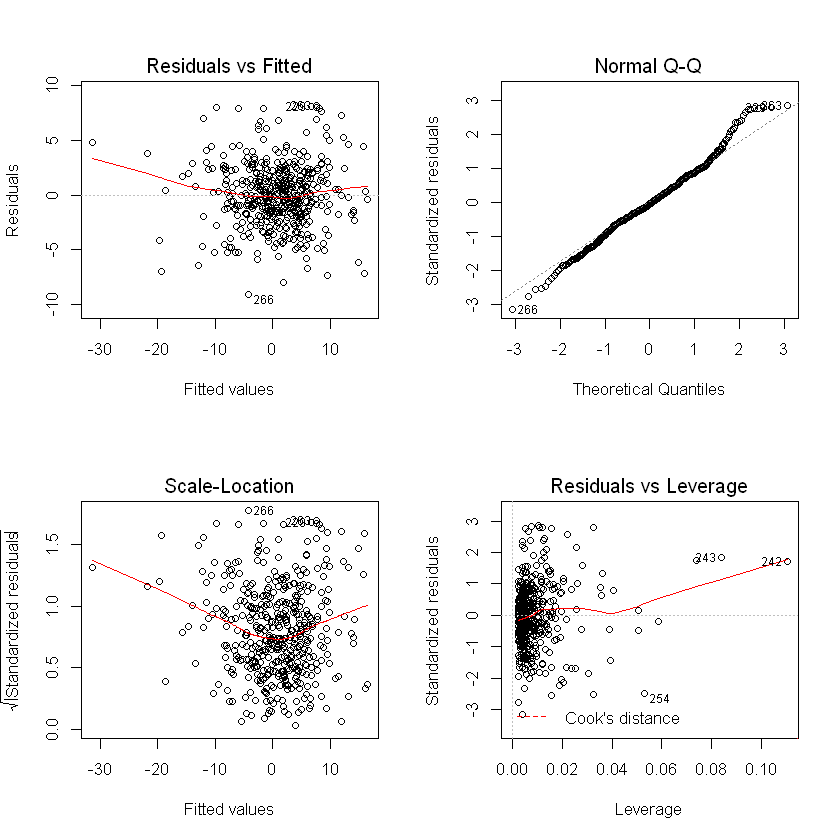

In [148]:
# Check for violation of Assumptions of Preffered Model

par(mfrow = c(2,2)); plot(l3_HiTec)

There does not appear to be any significant violations in the assumption of regression. There is no linear relationship or curvature in the residual vs fitted plot, hence the linearity assumption is not violated. On the residual vs fitted plot, there is some linear relationship in the range of the lower fitted values, however, this is a result of outliers pulling up the horizontal line and is hence not a legitimate issue. There is also no trumpeting pattern in the residual vs fitted plot so the constant variance assumption is not violated. While there is some deviation in normality in the tails of the normal q-q plot, this is the least important of the other assumptions. All else equal, unless the sample size is small, results are reasonably robust to deviations in normality.

In [149]:
# Checking for collinearity among predictors 

X_HiTec=model.matrix(l3_HiTec)
ev_HiTec = eigen(t(X_HiTec)%*%X_HiTec)
Condition_Number_HiTec = sqrt(ev_HiTec$values[1]/ev_HiTec$values[length(ev_HiTec$values)])
cat('The condition number for the regression run on the hitech industry is :',Condition_Number_HiTec)



The condition number for the regression run on the hitech industry is : 4.743328

Because the condition number is less than 30, there is no evidence of collinearity between predictors.


In [150]:
# Further investigation into collinearity among predictors

vif(l3_HiTec)

`Mkt-RF`      SMB      HML 
1.119495 1.052817 1.091377

Furthermore, VIFs of greater than 10 are evidence of collinearity since none of them are greater than 10 then there is no evidence of collinearty.

In [151]:
#LOOCV HiTec

LOOCV_HITEC_3 = function(df){
    sum_square_dev = 0
    for (i in 1:dim(df)[1]){
        test = df[i,]
        train = df[-i,]
        lmod = lm(`HiTec-RF` ~ `Mkt-RF`+`SMB`+`HML`, data = train)
        modelMatrix = model.matrix(lmod)
        newData = data.frame(aggregate[i,])%>% select(2:4)
        newData = newData %>% rename(`Mkt-RF` = `Mkt.RF`)
        predict = predict(lmod, newdata = newData)[[1]]
        HiTecActual = aggregate[i,] %>% select(12:12)
        true = HiTecActual[[1]]
        
        square_dev = (true - predict)^2
        sum_square_dev = sum_square_dev + square_dev
    }
    mean_sum_square_dev = mean(sum_square_dev)
    return(mean_sum_square_dev)
}

LOOCV_HITEC_1 = function(df){
    sum_square_dev = 0
    for (i in 1:dim(df)[1]){
        test = df[i,]
        train = df[-i,]
        lmod = lm(`HiTec-RF` ~ `Mkt-RF`, data = train)
        modelMatrix = model.matrix(lmod)
        newData = data.frame(aggregate[i,])%>% select(2:2)
        newData = newData %>% rename(`Mkt-RF` = `Mkt.RF`)
        predict = predict(lmod, newdata = newData)[[1]]
        HiTecActual = aggregate[i,] %>% select(12:12)
        true = HiTecActual[[1]]
        
        square_dev = (true - predict)^2
        sum_square_dev = sum_square_dev + square_dev
    }
    mean_sum_square_dev = mean(sum_square_dev)
    return(mean_sum_square_dev)
}

In [152]:
# Comparing the selected model to single predictor Leave-One-Out Cross Validation score:

cat('The hitech industry model with all three factors has a Leave-One-Out Cross Validation score of: ',LOOCV_HITEC_3(aggregate),"\n")

cat('The hitech industry model with the Mkt-Rf factor only has a Leave-One-Out Cross Validation score of: ',LOOCV_HITEC_1(aggregate),"\n")

The hitech industry model with all three factors has a Leave-One-Out Cross Validation score of:  3846.484 
The hitech industry model with the Mkt-Rf factor only has a Leave-One-Out Cross Validation score of:  5557.538 


In [153]:
# Utility Industry Analysis

lmod_Utils=lm(`Utils-RF` ~ `Mkt-RF`+`SMB`+`HML`, data = aggregate)
#summary(lmod_Utils)
#par(mfrow = c(2,2)); plot(lmod_Utils)

In [154]:
#Model Selection through Backwards Elimination (15% level)

summary(lmod_Utils)


Call:
lm(formula = `Utils-RF` ~ `Mkt-RF` + SMB + HML, data = aggregate)

Residuals:
     Min       1Q   Median       3Q      Max 
-10.1951  -2.0135   0.2293   1.8982   9.8216 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.21211    0.15169   1.398    0.163    
`Mkt-RF`     0.53029    0.03570  14.854  < 2e-16 ***
SMB         -0.24015    0.05270  -4.557 6.68e-06 ***
HML          0.32481    0.05273   6.160 1.61e-09 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 3.169 on 452 degrees of freedom
Multiple R-squared:  0.3389,	Adjusted R-squared:  0.3345 
F-statistic: 77.24 on 3 and 452 DF,  p-value: < 2.2e-16


The preffered model by Backwards Elimination is:

l3_Utils = lm(`Utils-RF` ~ `Mkt-RF`+`SMB`+`HML`, data = aggregate)

In [155]:
#Model Selection through Minimized AIC

b_Utils = regsubsets(`Utils-RF` ~ `Mkt-RF`+`SMB`+`HML`, data = aggregate)
rs_Utils = summary(b_Utils)
rs_Utils$which 

(Intercept),`Mkt-RF`,SMB,HML
TRUE,TRUE,FALSE,FALSE
TRUE,TRUE,FALSE,TRUE
TRUE,TRUE,TRUE,TRUE


In [156]:
l1_Utils = lm(`Utils-RF` ~ `Mkt-RF`, data = aggregate)
l2_Utils = lm(`Utils-RF` ~ `Mkt-RF`+`HML`, data = aggregate)
l3_Utils = lm(`Utils-RF` ~ `Mkt-RF`+`SMB`+`HML`, data = aggregate)

AIC(l1_Utils)
AIC(l2_Utils)
AIC(l3_Utils)

[1] 2408.2

[1] 2370.4

[1] 2351.915

The model that minimizes AIC is:

l3_Utils = lm(`Utils-RF` ~ `Mkt-RF`+`SMB`+`HML`, data = aggregate)

In [157]:
#Model selection through Maximization of Adjusted R-Squared

rs_Utils$adjr2

[1] 0.2437938 0.3054683 0.3345097

The model that maximizes Adjusted R-Squared:

l3_Utils = lm(`Utils-RF` ~ `Mkt-RF`+`SMB`+`HML`, data = aggregate)

Because all the methods of selection agree, Leave-One-Out Cross Validation analysis is not necessary. The preffered model is:

l3_Utils = lm(Utils-RF ~ Mkt-RF+SMB+HML, data = aggregate)

In [158]:
# Display Summary for Preffered Model

summary(l3_Utils)


Call:
lm(formula = `Utils-RF` ~ `Mkt-RF` + SMB + HML, data = aggregate)

Residuals:
     Min       1Q   Median       3Q      Max 
-10.1951  -2.0135   0.2293   1.8982   9.8216 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.21211    0.15169   1.398    0.163    
`Mkt-RF`     0.53029    0.03570  14.854  < 2e-16 ***
SMB         -0.24015    0.05270  -4.557 6.68e-06 ***
HML          0.32481    0.05273   6.160 1.61e-09 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 3.169 on 452 degrees of freedom
Multiple R-squared:  0.3389,	Adjusted R-squared:  0.3345 
F-statistic: 77.24 on 3 and 452 DF,  p-value: < 2.2e-16


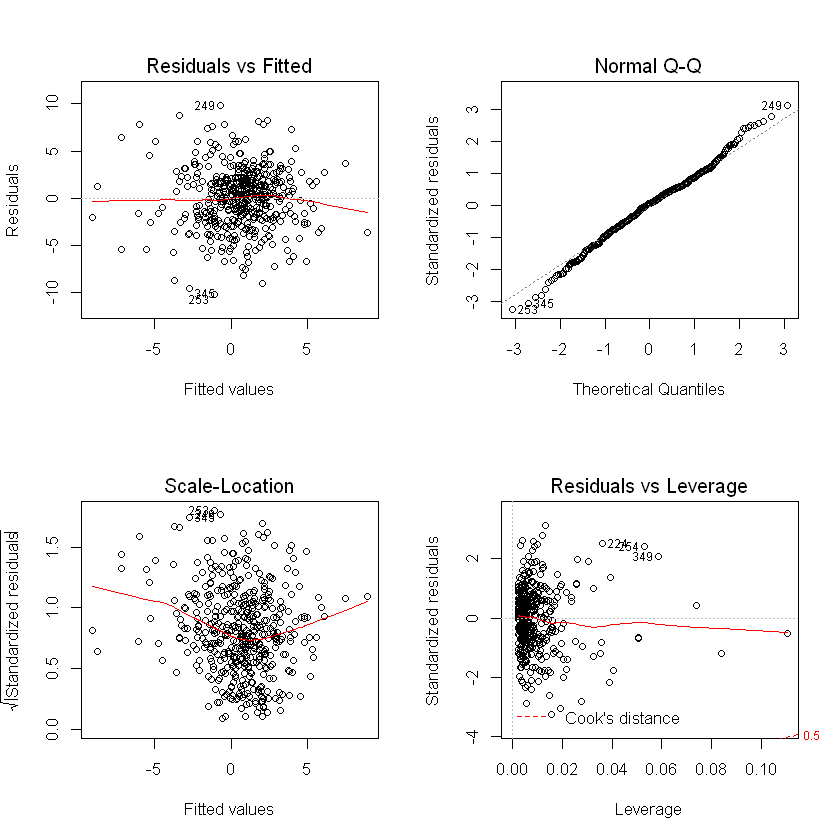

In [159]:
# Check for violation of Assumptions of Preffered Model

par(mfrow = c(2,2)); plot(l3_Utils)

There does not appear to be any significant violations in the assumption of regression. There is no linear relationship or curvature in the residual vs fitted plot, hence the linearity assumption is not violated. There is also no trumpeting pattern in the residual vs fitted plot so the constant variance assumption is not violated. While there is some deviation in normality in the tails of the normal q-q plot, this is the least important of the other assumptions. All else equal, unless the sample size is small, results are reasonably robust to deviations in normality.

In [160]:
# Checking for collinearity among predictors 

X_Utils=model.matrix(l3_Utils)
ev_Utils = eigen(t(X_Utils)%*%X_Utils)
Condition_Number_Utils = sqrt(ev_Utils$values[1]/ev_Utils$values[length(ev_Utils$values)])
cat('The condition number for the regression run on the utility industry is :',Condition_Number_Utils)


The condition number for the regression run on the utility industry is : 4.743328

Because the condition number is less than 30, there is no evidence of collinearity between predictors.


In [161]:
# Further investigation into collinearity among predictors

vif(l3_Utils)

`Mkt-RF`      SMB      HML 
1.119495 1.052817 1.091377

Furthermore, VIFs of greater than 10 are evidence of collinearity since none of them are greater than 10 then there is no evidence of collinearty.


In [162]:
#LOOCV UTILS

LOOCV_UTILS_3 = function(df){
    sum_square_dev = 0
    for (i in 1:dim(df)[1]){
        test = df[i,]
        train = df[-i,]
        lmod = lm(`Utils-RF` ~ `Mkt-RF`+`SMB`+`HML`, data = train)
        modelMatrix = model.matrix(lmod)
        newData = data.frame(aggregate[i,])%>% select(2:4)
        newData = newData %>% rename(`Mkt-RF` = `Mkt.RF`)
        predict = predict(lmod, newdata = newData)[[1]]
        UtilsActual = aggregate[i,] %>% select(13:13)
        true = UtilsActual[[1]]
        
        square_dev = (true - predict)^2
        sum_square_dev = sum_square_dev + square_dev
    }
    mean_sum_square_dev = mean(sum_square_dev)
    return(mean_sum_square_dev)
}

LOOCV_UTILS_1 = function(df){
    sum_square_dev = 0
    for (i in 1:dim(df)[1]){
        test = df[i,]
        train = df[-i,]
        lmod = lm(`Utils-RF` ~ `Mkt-RF`, data = train)
        modelMatrix = model.matrix(lmod)
        newData = data.frame(aggregate[i,])%>% select(2:2)
        newData = newData %>% rename(`Mkt-RF` = `Mkt.RF`)
        predict = predict(lmod, newdata = newData)[[1]]
        UtilsActual = aggregate[i,] %>% select(13:13)
        true = UtilsActual[[1]]
        
        square_dev = (true - predict)^2
        sum_square_dev = sum_square_dev + square_dev
    }
    mean_sum_square_dev = mean(sum_square_dev)
    return(mean_sum_square_dev)
}

In [163]:
# Comparing the selected model to single predictor Leave-One-Out Cross Validation score:

cat('The utility industry model with all three factors has a Leave-One-Out Cross Validation score of: ',LOOCV_UTILS_3(aggregate),"\n")

cat('The utility industry model with the Mkt-Rf factor only has a Leave-One-Out Cross Validation score of: ',LOOCV_UTILS_1(aggregate),"\n")

The utility industry model with all three factors has a Leave-One-Out Cross Validation score of:  4651.203 
The utility industry model with the Mkt-Rf factor only has a Leave-One-Out Cross Validation score of:  5239.086 


In [164]:
#Pre and post 2013 analysis

after_2013 = aggregate %>% filter(Year<201300)
before_2013 = aggregate %>% filter(Year>=201300)

In [165]:
Util_after_2013 = lm(`Utils-RF` ~ `Mkt-RF`+`SMB`+`HML`, data = after_2013)
Util_before_2013 = lm(`Utils-RF` ~ `Mkt-RF`+`SMB`+`HML`, data = before_2013)

HiTec_after_2013 = lm(`HiTec-RF` ~ `Mkt-RF`+`SMB`+`HML`, data = after_2013)
HiTec_before_2013 = lm(`HiTec-RF` ~ `Mkt-RF`+`SMB`+`HML`, data = before_2013)

Manuf_after_2013 = lm(`Manuf-RF` ~ `Mkt-RF`+`SMB`+`HML`, data = after_2013)
Manuf_before_2013 = lm(`Manuf-RF` ~ `Mkt-RF`+`SMB`+`HML`, data = before_2013)



In [166]:
cat('The utility industry model trained on pre 2013 data has an R-Squared of: ',summary(Util_before_2013)$r.squared,"\n")
cat('The utility industry model trained on post 2013 data has an R-Squared of: ',summary(Util_after_2013)$r.squared,"\n")


cat('The hitech industry model trained on pre 2013 data has an R-Squared of: ',summary(HiTec_before_2013)$r.squared,"\n")
cat('The hitech industry model trained on post 2013 data has an R-Squared of: ',summary(HiTec_after_2013)$r.squared,"\n")

cat('The manufacturing industry model trained on pre 2013 data has an R-Squared of: ',summary(Manuf_before_2013)$r.squared,"\n")
cat('The manufacturing industry model trained on post 2013 data has an R-Squared of: ',summary(Manuf_after_2013)$r.squared,"\n")



The utility industry model trained on pre 2013 data has an R-Squared of:  0.1472744 
The utility industry model trained on post 2013 data has an R-Squared of:  0.3749445 
The hitech industry model trained on pre 2013 data has an R-Squared of:  0.7891058 
The hitech industry model trained on post 2013 data has an R-Squared of:  0.8238605 
The manufacturing industry model trained on pre 2013 data has an R-Squared of:  0.9008318 
The manufacturing industry model trained on post 2013 data has an R-Squared of:  0.866544 


In [167]:
pred_Utils_before2013 = predict(Util_before_2013, before_2013, interval = "prediction")
mseTest_Utils_before2013 = mean((before_2013$`Utils-RF` - pred_Utils_before2013)^2); cat("The MSE for utility industry model before 2013 is", mseTest_Utils_before2013,"\n")

pred_Utils_after2013 = predict(Util_after_2013, after_2013, interval = "prediction")
mseTest_Utils_after2013 = mean((after_2013$`Utils-RF` - pred_Utils_after2013)^2); cat("The MSE for utility industry model after 2013 is", mseTest_Utils_after2013,"\n")


pred_HiTec_before2013 = predict(HiTec_before_2013, before_2013, interval = "prediction")
mseTest_HiTec_before2013 = mean((before_2013$`HiTec-RF` - pred_HiTec_before2013)^2); cat("The MSE for hitech industry model before 2013 is", mseTest_HiTec_before2013,"\n")

pred_HiTec_after2013 = predict(HiTec_after_2013, after_2013, interval = "prediction")
mseTest_HiTec_after2013 = mean((after_2013$`HiTec-RF` - pred_HiTec_after2013)^2); cat("The MSE for hitech industry model after 2013 is", mseTest_HiTec_after2013,"\n")


pred_Manuf_before2013 = predict(Manuf_before_2013, before_2013, interval = "prediction")
mseTest_Manuf_before2013 = mean((before_2013$`Manuf-RF` - pred_Manuf_before2013)^2); cat("The MSE for manufacturing industry model before 2013 is", mseTest_Manuf_before2013,"\n")

pred_Manuf_after2013 = predict(Manuf_after_2013, after_2013, interval = "prediction")
mseTest_Manuf_after2013 = mean((after_2013$`Manuf-RF` - pred_Manuf_after2013)^2); cat("The MSE for manufacturing industry model after 2013 is", mseTest_Manuf_after2013,"\n")




The MSE for utility industry model before 2013 is 41.13064 
The MSE for utility industry model after 2013 is 35.21721 
The MSE for hitech industry model before 2013 is 10.14786 
The MSE for hitech industry model after 2013 is 32.20841 
The MSE for manufacturing industry model before 2013 is 4.194385 
The MSE for manufacturing industry model after 2013 is 12.57748 


Conclusion on how well the three factor model performs before and after 2013

The utility industry model trained on pre 2013 data has a lower R-Squared than the utility industry model trained on post 2013 data meaning the model better explains returns in the utility industry after Fama and French had received the Nobel prize for their work. Additionally, the mean squared error for the model that was trained and tested on pre 2013 data is higher than for the model that was trained and tested on post 2013 data. This means there is less prediction error after 2013, suggesting the 3 factor model is more accurate for predicting utility industry returns have Fama and French recieved their nobel prize. The hitech industry model also sees an increase in R-Squared going from pre to post 2013, however, mean squared error rises so it is not conclusive as to whether or not the 3 factor model is better at making predictions in the hitech industry after the Nobel prize. This could potentially be a result of predictors being needed to predict the often more volatile returns in the hitech industry. The manufacturing industry model actually gets worse after 2013 as it sees a decrease in R-Squared and an increase in mean squared error. My thesis here is that in the years after the Nobel prize was awarded to Fama and French, many other models with more predictors were developed and so returns are most likely more accurately described by these such models. It may also be a coincidence that the returns in the manufacturing industry led to such results.